In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
print('Training shape:',traindf.shape)
print('Testing shape:',testdf.shape)
traindf.head()

Training shape: (891, 12)
Testing shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Name,Ticket are all unique and might not hold any important information, so removing them
cols = ['Name','Ticket']
traindf = traindf.drop(columns=cols,axis=1)
testdf = testdf.drop(columns=cols,axis=1)

In [4]:
#Because Fare also isn't very helpful, dropping it as well
traindf = traindf.drop(['Fare'],axis=1)
testdf = testdf.drop(['Fare'],axis=1)
traindf.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,1,0,3,male,22.0,1,0,NaN,S
1,2,1,1,female,38.0,1,0,C85,C
2,3,1,3,female,26.0,0,0,NaN,S
3,4,1,1,female,35.0,1,0,C123,S
4,5,0,3,male,35.0,0,0,NaN,S


In [5]:
#Pclass is a type of passenger class and would be better judged as categorical variable, so changing it 
traindf['Pclass'] = traindf.Pclass.astype('object')
testdf['Pclass'] = testdf.Pclass.astype('object')
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Cabin        204 non-null    object 
 8   Embarked     889 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 62.8+ KB


In [6]:
#change sex variable to 0 or 1 numerical, where 0 is male and 1 is female
traindf['Sex'] = traindf['Sex'].map(lambda x: 0 if x=='male' else '1').astype('int64')
testdf['Sex'] = testdf['Sex'].map(lambda x: 0 if x=='male' else '1').astype('int64')


In [7]:
#Check data description
traindf.describe()

,PassengerId,Survived,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,0.352413,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.477990,14.526497,1.102743,0.806057
min,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,0.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,0.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,1.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,1.000000,80.000000,8.000000,6.000000


In [8]:
#Check if there are any null values present in the columns
(traindf.isnull().sum()/traindf.shape[0])*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [9]:
#Cabin column has around 77% data missing, so remove the column as imputing it may not be a good option
traindf = traindf.drop(['Cabin'],axis=1)
testdf = testdf.drop(['Cabin'],axis=1)
traindf.describe()

,PassengerId,Survived,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,0.352413,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.477990,14.526497,1.102743,0.806057
min,1.000000,0.000000,0.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,0.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,0.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,1.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,1.000000,80.000000,8.000000,6.000000


In [10]:
#For the Age columns, let's remove the rows with missing Age
traindf = traindf[~traindf['Age'].isna()]
traindf.shape

(714, 8)

In [11]:
#Let's create dummy variables for Pclass and Embarked
cols = ['Pclass','Embarked']

dummies = pd.get_dummies(traindf['Pclass'])
traindf = pd.concat([traindf,dummies],axis=1)

dummies = pd.get_dummies(traindf['Embarked'])
traindf = pd.concat([traindf,dummies],axis=1)

traindf = traindf.drop(cols,axis=1)
traindf.info()

dummies = pd.get_dummies(testdf['Pclass'])
testdf = pd.concat([testdf,dummies],axis=1)

dummies = pd.get_dummies(testdf['Embarked'])
testdf = pd.concat([testdf,dummies],axis=1)

testdf = testdf.drop(cols,axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Sex          714 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        714 non-null    int64  
 5   Parch        714 non-null    int64  
 6   1            714 non-null    uint8  
 7   2            714 non-null    uint8  
 8   3            714 non-null    uint8  
 9   C            714 non-null    uint8  
 10  Q            714 non-null    uint8  
 11  S            714 non-null    uint8  
dtypes: float64(1), int64(5), uint8(6)
memory usage: 43.2 KB


In [12]:
#Train test split
X = traindf.drop(['Survived'],axis=1)
y = traindf['Survived']
X.head()


,PassengerId,Sex,Age,SibSp,Parch,1,2,3,C,Q,S
0,1,0,22.0,1,0,0,0,1,0,0,1
1,2,1,38.0,1,0,1,0,0,1,0,0
2,3,1,26.0,0,0,0,0,1,0,0,1
3,4,1,35.0,1,0,1,0,0,0,0,1
4,5,0,35.0,0,0,0,0,1,0,0,1


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=100)
X_train.head()

,PassengerId,Sex,Age,SibSp,Parch,1,2,3,C,Q,S
252,253,0,62.0,0,0,1,0,0,0,0,1
307,308,1,17.0,1,0,1,0,0,1,0,0
536,537,0,45.0,0,0,1,0,0,0,0,1
435,436,1,14.0,1,2,1,0,0,0,0,1
526,527,1,50.0,0,0,0,1,0,0,0,1


In [14]:
print("Train",X_train.shape)
print("Test",X_test.shape)

Train (535, 11)
Test (179, 11)


In [15]:
#Scaling
sclr = MinMaxScaler()
X_train[X.columns] = sclr.fit_transform(X_train[X.columns])
X_train.head()

,PassengerId,Sex,Age,SibSp,Parch,1,2,3,C,Q,S
252,0.283146,0.0,0.773100,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
307,0.344944,1.0,0.205849,0.2,0.000000,1.0,0.0,0.0,1.0,0.0,0.0
536,0.602247,0.0,0.558805,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
435,0.488764,1.0,0.168032,0.2,0.333333,1.0,0.0,0.0,0.0,0.0,1.0
526,0.591011,1.0,0.621833,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0


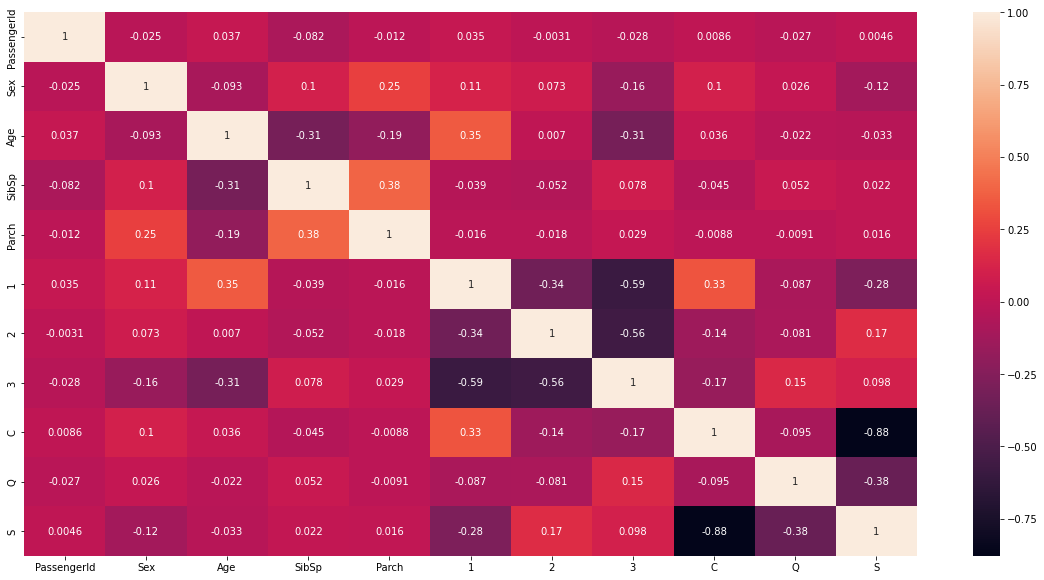

In [16]:
#Let's check the correlation matrix
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X.corr(),annot = True)
plt.show()

In [17]:
#Using RandomForestClassifier 

rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=100, oob_score=True)

In [18]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 109 ms
Wall time: 131 ms


RandomForestClassifier(max_depth=4, oob_score=True, random_state=100)

In [19]:
#Let's check the OOB score
rf.oob_score_

0.8018691588785046

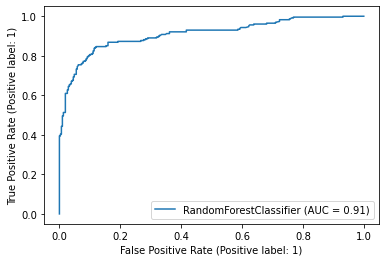

In [20]:
plot_roc_curve(rf, X_train, y_train)
plt.show()

In [21]:
#Let's try to come up with a RF estimator with Hypertuning

hrf = RandomForestClassifier(random_state=100, n_jobs=-1)

In [22]:
params = {
    'max_depth': [2,3,5,7,10,20],
    'n_estimators': [10,25,50,100,150,200]
}

grid_search = GridSearchCV(estimator=hrf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [23]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
CPU times: total: 609 ms
Wall time: 10.9 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7, 10, 20],
                         'n_estimators': [10, 25, 50, 100, 150, 200]},
             scoring='accuracy', verbose=1)

In [24]:
#Let's check the best score
grid_search.best_score_

0.8093648299854113

In [25]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1,
                       random_state=100)

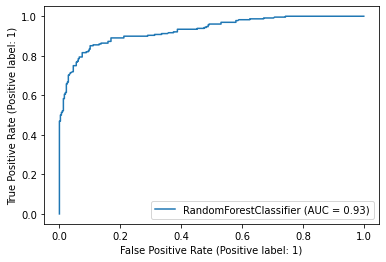

In [26]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

In [27]:
rf_best.feature_importances_

array([0.10192801, 0.4112323 , 0.11054578, 0.04725068, 0.03966537,
       0.10513287, 0.01891662, 0.11677189, 0.01982207, 0.01044796,
       0.01828645])

In [28]:
#Let's check the important features that the model has decided for us
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
1,Sex,0.411232
7,3,0.116772
2,Age,0.110546
5,1,0.105133
0,PassengerId,0.101928
3,SibSp,0.047251
4,Parch,0.039665
8,C,0.019822
6,2,0.018917
10,S,0.018286


In [29]:
#With this, the model determines
# ----------------------> Sex as the most important feature
# ----------------------> Passenger class 3 (Lower) as the second most important
# ----------------------> Age as the 3rd most important

In [30]:
#Evaluating the model

#Generic method to check the accuracy score and confusion matrix

def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [31]:
#Evaluate our best model vs our basic model

evaluate_model(rf_best)
print("************************")
print("************************")
evaluate_model(rf)

Train Accuracy : 0.8710280373831776
Train Confusion Matrix:
[[287  20]
 [ 49 179]]
--------------------------------------------------
Test Accuracy : 0.8044692737430168
Test Confusion Matrix:
[[110   7]
 [ 28  34]]
************************
************************
Train Accuracy : 0.8579439252336448
Train Confusion Matrix:
[[288  19]
 [ 57 171]]
--------------------------------------------------
Test Accuracy : 0.8156424581005587
Test Confusion Matrix:
[[112   5]
 [ 28  34]]


In [32]:
#Let's check the classification reports
from sklearn.metrics import classification_report

print("Classification report for a simple RandomForestClassifier:")
print("")
print(classification_report(y_test,rf.predict(X_test)))

print("Classification report for a  RandomForestClassifier with Hyperparameter tuning:")
print("")
print(classification_report(y_test,rf_best.predict(X_test)))

Classification report for a simple RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       117
           1       0.87      0.55      0.67        62

    accuracy                           0.82       179
   macro avg       0.84      0.75      0.77       179
weighted avg       0.82      0.82      0.80       179

Classification report for a  RandomForestClassifier with Hyperparameter tuning:

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       117
           1       0.83      0.55      0.66        62

    accuracy                           0.80       179
   macro avg       0.81      0.74      0.76       179
weighted avg       0.81      0.80      0.79       179



In [34]:
abc = testdf.copy()

In [35]:
testdf['Age'].fillna(testdf['Age'].mean(),inplace=True)
testdf.isna().sum()

PassengerId    0
Sex            0
Age            0
SibSp          0
Parch          0
1              0
2              0
3              0
C              0
Q              0
S              0
dtype: int64

In [36]:
# ###############################################
#
#
# our tuned model can be selected as final model.
# Let's generate the output using our final model
testdf[testdf.columns] = sclr.transform(testdf[testdf.columns])
#Create a report based on our final model
ytest_pred = rf_best.predict(testdf)


In [39]:
#Create a report based on our final model
df_result = pd.DataFrame(ytest_pred, columns=['Survived'],index=np.arange(892,1310))
df_result.to_csv('submission.csv',index_label='PassengerId')